# Import libraries

In [ ]:
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from skimage import io,data,color,exposure,transform

%matplotlib inline

In [5]:
from sklearn import preprocessing, svm

In [6]:
import sklearn
sklearn.__version__

'0.21.3'

# Load Image

In [10]:
import os

def get_folder_name_in_int(image_folder):
    folder_names = os.listdir(image_folder)
    folder_names_numeric = []
    for folder_name in folder_names:
        folder_names_numeric.append(int(folder_name))    
    folder_names_numeric.sort()
    return folder_names_numeric

In [11]:
import warnings
warnings.filterwarnings("ignore")
image_folder = r'./Contest_train_After'
folder_name = get_folder_name_in_int(image_folder)  # [3, 5, 17, 18, 19, 21, 22, 43, 45, 46, 55, 56, 59, 63, 67, 69, 71, 72, 73, 74, 77]  # folder names
folder_name

[5, 22, 34, 46, 55, 56, 58, 59, 63, 65]

Read one picture as skimage and plot

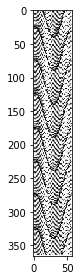

In [12]:
sk_image = io.imread(image_folder+'/5/img35.jpeg')
io.imshow(sk_image)

# Preprocess pictures

In [13]:
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import rescale, resize, downscale_local_mean
# f as picture file name
def pic_preprocess(f): 
    processed_image = []
    # Read the picture as skimage
    sk_image = io.imread(f)
    # Convert the skimage from RGB to gray scale
    img_gray = rgb2gray(sk_image)
    # Resize the picture to a fixed size of pixels
    processed_image = resize(img_gray, (25, 25), anti_aliasing = True)
    ##processed_image = resize(sk_image, (200, 200))
    # Return preprocessed picture
    return processed_image

In [14]:
# Normalize the range of grayscale to [0,1] to maximize the contrast
def pic_normalization(pic):
    pic = pic-pic.min()
    pic = pic/pic.max()
    # Recover range to [0,255] and return
    return pic*255

## Picture Preprocessing Result

Text(0.5, 1, 'Normalized')

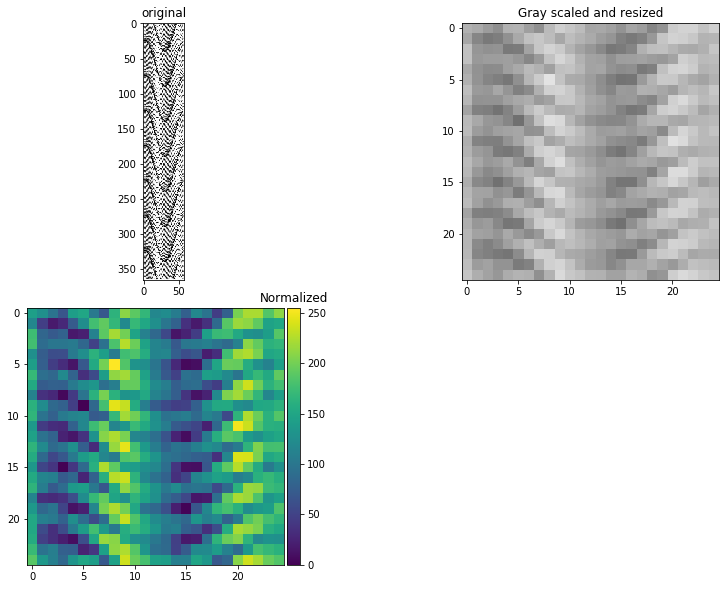

In [16]:
sk_image = io.imread(image_folder+'/5/img35.jpeg')
plt.figure("hist",figsize=(12,12))
plt.subplot(321)
io.imshow(sk_image)
plt.title('original')

plt.subplot(322)
sk_image2 = pic_preprocess(image_folder+'/5/img35.jpeg')
io.imshow(sk_image2)
plt.title('Gray scaled and resized')

plt.subplot(323)
sk_image3 = pic_normalization(sk_image2)
io.imshow(sk_image3)
plt.title('Normalized')

## Prepare Training data

In [17]:
### The purpose of this function is to read, preprocess, normalize and reshape a picture ## 
def batch_process(pic_path):
    sk_image = pic_preprocess(pic_path)
    sk_image = pic_normalization(sk_image).astype(np.uint8)
    # Reshape sk_image from matrix to 1-dimensional array
    image_array = sk_image.flatten()
    
    return image_array

In [18]:
import os, fnmatch
data_x = []
data_y = []
print('Image folders are:')
for i in range(len(folder_name)):
    pic_folder=image_folder+ '/'+ str(folder_name[i])+'/'
    file_names = fnmatch.filter(os.listdir(pic_folder), '*.jpeg')
    print(pic_folder)
    t = 0
    for j in range(len(file_names)):
        img = batch_process(pic_folder+file_names[j])
        data_x.append(img)
        data_y.append(folder_name[i])
data_X = np.array(data_x)
data_Y = np.array(data_y)
print('The shape of feature set (set of image arrays) is: ',data_X.shape)
print('The shape of label is: ',data_Y.shape)

Image folders are:
./Contest_train_After/5/
./Contest_train_After/22/
./Contest_train_After/34/
./Contest_train_After/46/
./Contest_train_After/55/
./Contest_train_After/56/
./Contest_train_After/58/
./Contest_train_After/59/
./Contest_train_After/63/
./Contest_train_After/65/
The shape of feature set (set of image arrays) is:  (4888, 625)
The shape of label is:  (4888,)


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=23) # Split data_X and data_Y to train set and test set

# Train a random forest classifier

In [29]:
print(X_train.shape,
    y_train.shape,
    X_test.shape,
    y_test.shape)

(3910, 625) (3910,) (978, 625) (978,)


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, recall_score, precision_score, log_loss


def rft_model(X_train, y_train, X_valid, y_valid):
    train_model = RandomForestClassifier(random_state=0) # Create a Random Forest Classifier
    train_model.fit(X_train, y_train) # Train RandForestClassifier with X_train and y_train
    #print(X_valid)
    y_predict = train_model.predict(X_valid)# Predict using X_valid
    #print(y_predict)
    rft_result_accuracy = accuracy_score(y_valid, y_predict) # Compute accuracy
    return rft_result_accuracy, train_model

rft_accuracy, rft_model = rft_model(X_train, y_train, X_test, y_test)
print(rft_accuracy)

0.4488752556237219


In [31]:
# find the best n_estimators for RandomForestClassifier
print('Finding best n_estimators for RandomForestClassifier...')
max_score = -1
best_n = 0
scores_n = []
range_n = [1, 10, 100, 200]  # np.logspace(0,2,num=3).astype(int)
for n in range_n:
    print("the number of trees : {0}".format(n))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(n_estimators=n, oob_score=False, random_state=10, n_jobs=-1)
    kf = KFold(n_splits=10, shuffle=True)
    for train_k, test_k in kf.split(data_X):
        rfc.fit(pd.DataFrame(data_X).iloc[train_k], pd.DataFrame(data_Y).iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(data_X[test_k])
        rfc_score += accuracy_score(data_Y[test_k], pred) / 10
    scores_n.append(rfc_score)
    if rfc_score > max_score:
        max_score = rfc_score
        best_n = n
        
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(n, t2-t1))
print('best_n_estimators={0}, max_score={1}'.format(best_n, max_score))

Finding best n_estimators for RandomForestClassifier...
the number of trees : 1
Done processing 1 trees (2.538sec)
the number of trees : 10
Done processing 10 trees (6.300sec)
the number of trees : 100
Done processing 100 trees (41.340sec)
the number of trees : 200
Done processing 200 trees (77.644sec)
best_n_estimators=200, max_score=0.6859629052264574


In [32]:
# find best max_depth for RandomForestClassifier
print('Finding best max_depth for RandomForestClassifier...')
max_score = -1
best_m = 0
scores_m = []
range_m = [1, 10, 100]  # np.logspace(0,2,num=3).astype(int)
for m in range_m:
    print("the max depth : {0}".format(m))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(max_depth=m, n_estimators=best_n, n_jobs=-1)
    kf = KFold(n_splits=10, shuffle=True)
    for train_k, test_k in kf.split(data_X):
        rfc.fit(data_X[train_k], data_Y[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(data_X[test_k])
        rfc_score += accuracy_score(data_Y[test_k], pred) / 10
    scores_m.append(rfc_score)
    if rfc_score > max_score:
        max_score = rfc_score
        best_m = m
    
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(m, t2-t1))
print('best_max_depth={0}, max_score={1}'.format(best_m, max_score))

Finding best max_depth for RandomForestClassifier...
the max depth : 1
Done processing 1 trees (9.684sec)
the max depth : 10
Done processing 10 trees (46.015sec)
the max depth : 100
Done processing 100 trees (61.292sec)
best_max_depth=100, max_score=0.688623068155151


Show accuracy of the Random Forest model in the validation set

In [33]:
print(best_n, best_m)

200 100


In [34]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm

clf_ExT = ExtraTreesClassifier(n_estimators=best_n, max_depth=best_m, random_state=0)
scores_EXT = cross_val_score(clf_ExT, data_X, data_Y, cv = 5)
is_better = (scores_EXT.mean() > max_score)

print(scores_EXT.mean(), 'Better than the Random Forest:', is_better)

0.6947478639421825 Better than the Random Forest: True


In [35]:
def build_final_model(model, X_train, y_train, X_test):
#     t1 = time.time()

    # model = RandomForestClassifier(n_estimators=best_n, max_depth=best_m, n_jobs=-1)
#     model = RandomForestClassifier(n_estimators=best_n, max_depth=best_m, n_jobs=-1)
    
    model.fit(X_train, y_train)

    t2 = time.time()
#     print('Done processing {0} trees ({1:.3f}sec)'.format(best_n, t2-t1))

    pred_result = model.predict(X_test)
    return pred_result

In [36]:
if is_better == True:
    y_pred = build_final_model(ExtraTreesClassifier(n_estimators=best_n, max_depth=best_m, n_jobs=-1), X_train, y_train, X_test)
else:
    y_pred = build_final_model(RandomForestClassifier(n_estimators=best_n, max_depth=best_m, n_jobs=-1), X_train, y_train, X_test)
y_pred

array([46, 59, 22, 46, 46, 65, 46,  5, 34, 56, 34, 58, 65, 46,  5, 56, 65,
       46, 22, 55, 55, 63, 59, 56, 46, 59, 46, 55, 22, 22, 55, 58, 59, 22,
       22, 58, 59, 34, 34, 55, 22, 55, 46, 58, 65, 34, 55, 34, 34, 59, 58,
       59, 22, 58, 56, 46, 46, 34, 46, 22, 56, 22, 34, 65, 65, 59, 56, 58,
       34, 22, 59, 55, 59, 58, 34, 34,  5, 55, 22, 46, 63,  5, 22, 56, 59,
       46, 34, 65, 55, 34, 34, 55, 56,  5, 55, 22, 56, 22, 56, 63, 58, 63,
        5,  5, 22, 56, 22, 46,  5, 65, 63,  5, 65, 56, 65, 22, 22, 59, 22,
       56, 56, 56, 58, 63, 58, 46, 58, 22, 65, 46, 46, 46, 65, 59, 34, 46,
       55, 59, 65, 22, 22, 46, 59, 55, 63, 59, 22, 65, 65, 22, 46, 63, 34,
       63, 46, 56, 63, 59, 65, 34, 56, 59, 22, 59, 56,  5, 34, 58, 46, 65,
        5, 34, 46, 22, 56, 63, 55, 59, 22,  5, 59, 34, 65, 63, 46, 22, 56,
       58, 59, 58, 59, 58, 22, 56, 34, 65, 65, 34,  5, 56,  5, 34, 58, 22,
       58, 63, 58, 59, 56, 34, 63, 22, 55, 63, 58, 63, 22, 56, 65, 59, 55,
       59, 65, 63, 22, 63

In [37]:
def compare_y_test_to_benchmark(benchmark, y_test):
    start_idx = 100
    stop_idx = 200
    x = range(stop_idx-start_idx)
    y1 = y_test[start_idx:stop_idx]
    y2 = benchmark[start_idx:stop_idx]
    
    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(x,y2, "b", label='benchmark')
    plt.plot(x,y1, "g", label='predict')
    plt.legend()
    plt.show()
    
    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(benchmark, y_test, 'bo', label='Predicted')
    plt.plot(benchmark, benchmark, 'g', label='Line')
    plt.ylabel('shot made probability')
    plt.legend()
    plt.show()

#     print("Logloss is", logloss(benchmark, y_test)) # The smaller the better
    print("accuracy_score is ", accuracy_score(benchmark, y_test))

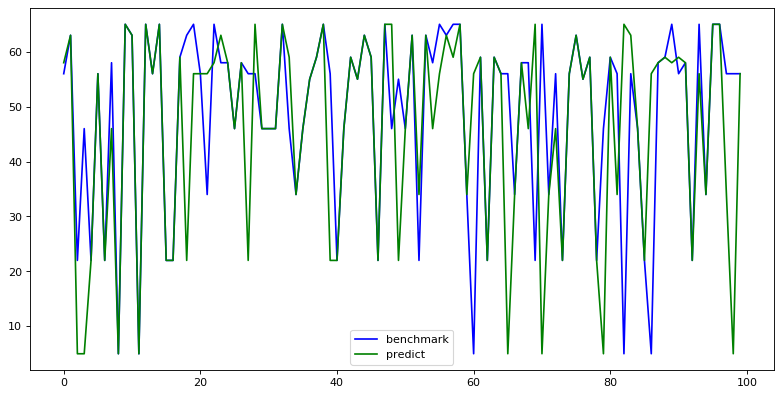

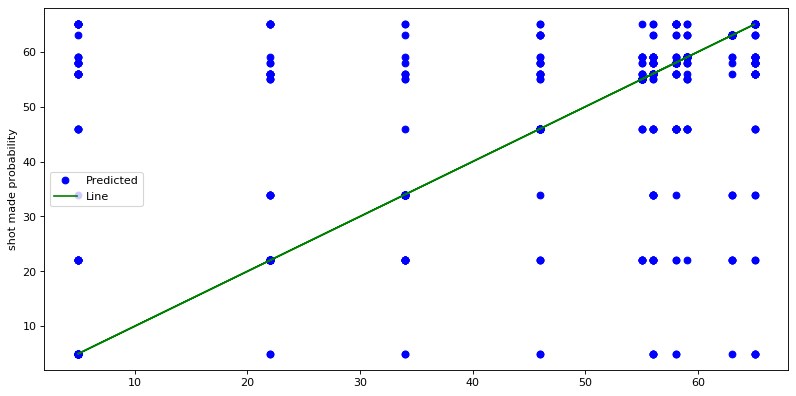

accuracy_score is  0.7096114519427403


In [38]:
# bench_data = pd.read_csv("benchmark.csv")
# benchmark = bench_data['shot_made_flag'].values
y_test.shape
y_pred.shape
compare_y_test_to_benchmark(y_test, y_pred)

# Build the final model

In [39]:
if is_better == True:
    final_model = ExtraTreesClassifier(n_estimators=best_n, max_depth=best_m, n_jobs=-1)
else:
    final_model = RandomForestClassifier(n_estimators=best_n, max_depth=best_m, n_jobs=-1)
final_model.fit(data_X, data_Y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=100, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

# Try to predict one picture

In [40]:
def FinalModelPredict(imgPath, final_model):
    X = []
    sk_image = batch_process(imgPath)
    # Reshape sk_image
    X.append(sk_image)
#     sk_image = sk_image.reshape(1,625)
    print(sk_image)
    result = final_model.predict(X)
    return result

In [41]:
imagePath = r"./TestData/Task1 (1).jpeg"
print('Image {0} should be {1}'.format(imagePath, FinalModelPredict(imagePath, final_model)[0]))

[104 136 201 204 199 190 185 178 179 183 185  58  58  83  36  65 112 155
 197 243 245 175  90 132 152 104  59  65 112 145 145 142 140 127  94  93
  53  16  56  53  23  62 127 175 224 186 110 139 101 106 137  29  63 160
 184 181 178 177 183 139  69  87  47  21  64  70  50  73 115 132 161 202
 167  55 127 119  25 147 185 186 182 177 168 174 176  85  56  79  30  30
  78 107 134 168 218 255 212 118  63 186  93  29  67  69  92 123 137 117
  93 108  91  29  57  66  22  38  93 138 185 224 223 148  80 122 154 112
  56  20  58 141 168 171 169 123  89 116  84  27  58  63  25  39  87 144
 162 128 115 155 108 147 147  37  44 154 176 174 169 166 165 115  72 104
  59  20  58  82  77  73 104 140 189 218 162  57 164 116  11  40  80  89
  90 114 120 129 120  58  61  86  30  21  71 107 141 182 227 242 194  99
  71 168 100  44  50  33  48  99 132 136 146 168 132  39  57  73  29  24
  62 119 171 192 164 101  89 126 197 120  66  22  42 136 160 163 157 123
  92 136  86  21  57  71  45  26  46  90 103 104 14

# Save pickle data

In [42]:
import pickle

def save_model(model, path):
  f = open(path,'wb')
  pickle.dump(model, f)

save_model(final_model,'ironman.pkl') 

In [46]:
def get_test_data(folder):
    X_test = []
    print('Image folders are:{0}'.format(folder))

    file_names = fnmatch.filter(os.listdir(folder), '*.jpeg')
#     coll.sort(key=lambda x:int(x[:-5]))
    file_names.sort(key=lambda x:len(x))  # take care of folder sequence, 1.jpeg, 2.jpeg, 3.jpeg
    print(file_names)
    
    for j in range(len(file_names)):
        img = batch_process(folder+file_names[j])
        X_test.append(img)

    X_test = np.array(X_test)
    print('The shape of feature set (set of image arrays) is: ',X_test.shape)
    return X_test
# data_Y = np.array(data_y)
    
# print('The shape of label is: ',data_Y.shape)

In [47]:
def predict_and_save_data_to_file(final_model, data, out_file_name):
    y_predict = final_model.predict(data)
    y_predict_df = pd.DataFrame(y_predict)
    print(y_predict_df.shape)
    print(y_predict_df.head())
    print('y_predict are saved in file {0}'.format(out_file_name))
    y_predict_df.to_csv(out_file_name, header=False, index=False, encoding='ansi')
    return y_predict_df

## Handle TestData_Part1

In [49]:
# read and predict test_data_part1
test_image_folder1 = r'./TestData/'
X_test_part1 = get_test_data(test_image_folder1)
X_test_part1.shape
y_predict1 = predict_and_save_data_to_file(final_model, X_test_part1, 'Ironman_part_1.csv')

Image folders are:./TestData/
['Task1 (1).jpeg', 'Task1 (2).jpeg', 'Task1 (3).jpeg', 'Task1 (4).jpeg', 'Task1 (5).jpeg', 'Task1 (6).jpeg', 'Task1 (7).jpeg', 'Task1 (8).jpeg', 'Task1 (9).jpeg', 'Task1 (10).jpeg', 'Task1 (11).jpeg', 'Task1 (12).jpeg', 'Task1 (13).jpeg', 'Task1 (14).jpeg', 'Task1 (15).jpeg', 'Task1 (16).jpeg', 'Task1 (17).jpeg', 'Task1 (18).jpeg', 'Task1 (19).jpeg', 'Task1 (20).jpeg', 'Task1 (21).jpeg', 'Task1 (22).jpeg', 'Task1 (23).jpeg', 'Task1 (24).jpeg', 'Task1 (25).jpeg', 'Task1 (26).jpeg', 'Task1 (27).jpeg', 'Task1 (28).jpeg', 'Task1 (29).jpeg', 'Task1 (30).jpeg', 'Task1 (31).jpeg', 'Task1 (32).jpeg', 'Task1 (33).jpeg', 'Task1 (34).jpeg', 'Task1 (35).jpeg', 'Task1 (36).jpeg', 'Task1 (37).jpeg', 'Task1 (38).jpeg', 'Task1 (39).jpeg', 'Task1 (40).jpeg', 'Task1 (41).jpeg', 'Task1 (42).jpeg', 'Task1 (43).jpeg', 'Task1 (44).jpeg', 'Task1 (45).jpeg', 'Task1 (46).jpeg', 'Task1 (47).jpeg', 'Task1 (48).jpeg', 'Task1 (49).jpeg', 'Task1 (50).jpeg', 'Task1 (51).jpeg', 'Task1 (5

## Handle TestData_Part2

In [ ]:
# rename jpg to jpeg
import os
test_image_folder2 = r'./TestData_Part2/test/'
file_names = fnmatch.filter(os.listdir(test_image_folder2), '*.jpg')
for item_jpg in file_names:
    os.rename(test_image_folder2+item_jpg, test_image_folder2+item_jpg[:-3]+'jpeg')

In [ ]:
# read and predict test_data_part2
X_test_part2 = get_test_data(test_image_folder2)
X_test_part2.shape
y_predict2 = predict_and_save_data_to_file(final_model, X_test_part2, 'Ironman_part_2.csv')